## Detecting communities in the rock network

### *Import network*

In [ ]:
import json, random, math, re, unicodedata
import networkx as nx
from collections import defaultdict, Counter
from networkx.algorithms.community.quality import modularity as nx_modularity

### *Map extracted genres to the rock network*

In [79]:
# Load the prebuilt processed data from genres extraction
print("Loading pre-processed network and genre mappings...")
H = nx.read_gexf("../genres/rock_network_with_genres.gexf")
resolved = json.load(open("../genres/resolved_mapping.json", encoding="utf-8"))
genres_raw = json.load(open("../genres/genres.json", encoding="utf-8"))

print(f"Loaded subgraph: {H.number_of_nodes():,} nodes, {H.number_of_edges():,} edges")

Loading pre-processed network and genre mappings...
Loaded subgraph: 485 nodes, 8,019 edges


### *Genre communities and modularity*

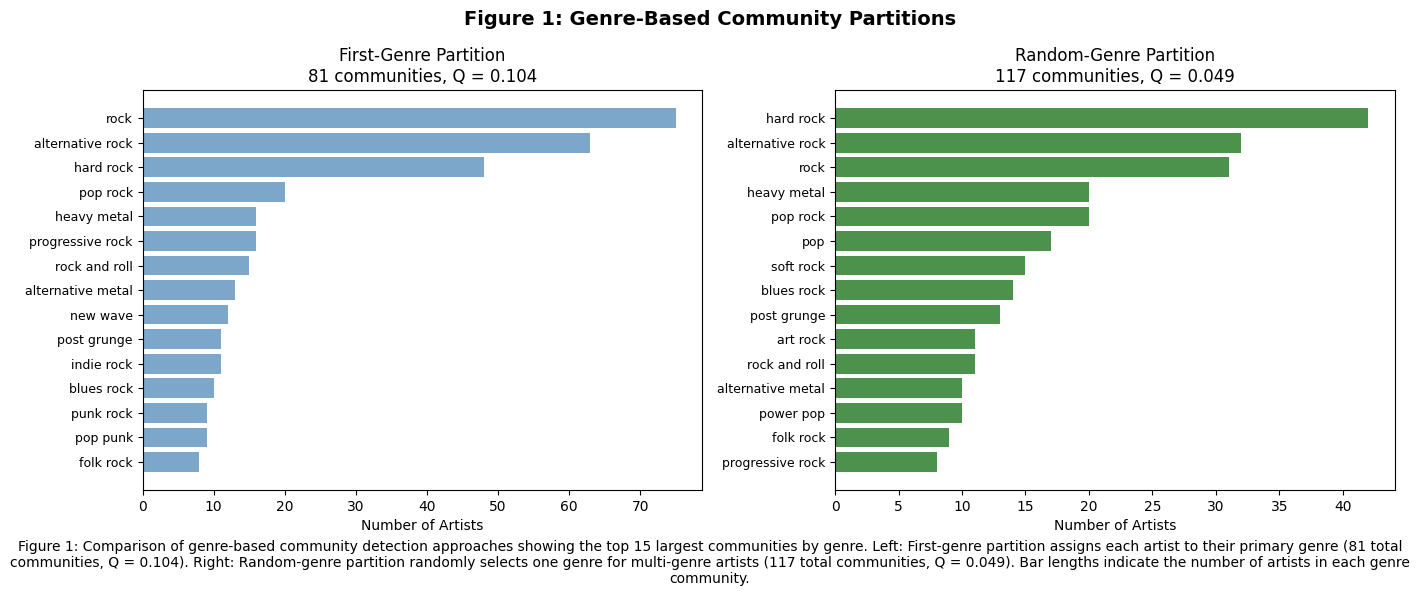

In [80]:
import random
from collections import defaultdict, Counter
import networkx as nx
from networkx.algorithms.community.quality import modularity as nx_modularity

# ---------- config ----------
RANDOM_SEED = 42
# ---------------------------

assert 'H' in globals()
assert 'resolved' in globals()

# Helper: get genre list for a node
def get_genres(n):
    # Get the JSON key for this node
    json_key = resolved[n]
    # Get the genres list from the raw genres data
    gl = genres_raw.get(json_key, [])
    return [g for g in gl if str(g).strip()]

# Build communities from node labels
def communities_from_labels(graph, labels_dict):
    groups = defaultdict(set)
    for node, label in labels_dict.items():
        groups[label].add(node)
    return [s for s in groups.values() if s]


# A) FIRST GENRE PARTITION
labels_first = {}
for n in H.nodes():
    gl = get_genres(n)
    if not gl:
        continue
    labels_first[n] = gl[0]

comms_first = communities_from_labels(H, labels_first)
Q_first = nx_modularity(H, comms_first)

# B) RANDOM GENRE PARTITION  
rng = random.Random(RANDOM_SEED)
labels_rand = {}
for n in H.nodes():
    gl = get_genres(n)
    if not gl:
        continue
    labels_rand[n] = gl[0] if len(gl) == 1 else rng.choice(gl)

comms_rand = communities_from_labels(H, labels_rand)
Q_rand = nx_modularity(H, comms_rand)

# Create visualization of genre partitions
import matplotlib.pyplot as plt
import pandas as pd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First genre partition
counts_first = Counter(labels_first.values())
top_15_first = counts_first.most_common(15)
df_first = pd.DataFrame(top_15_first, columns=['Genre', 'Artists'])

ax1.barh(range(len(df_first)), df_first['Artists'], color='steelblue', alpha=0.7)
ax1.set_yticks(range(len(df_first)))
ax1.set_yticklabels([g[:20] + '...' if len(g) > 20 else g for g in df_first['Genre']], fontsize=9)
ax1.set_xlabel('Number of Artists')
ax1.set_title(f'First-Genre Partition\n{len(counts_first)} communities, Q = {Q_first:.3f}')
ax1.invert_yaxis()

# Random genre partition
counts_rand = Counter(labels_rand.values())
top_15_rand = counts_rand.most_common(15)
df_rand = pd.DataFrame(top_15_rand, columns=['Genre', 'Artists'])

ax2.barh(range(len(df_rand)), df_rand['Artists'], color='darkgreen', alpha=0.7)
ax2.set_yticks(range(len(df_rand)))
ax2.set_yticklabels([g[:20] + '...' if len(g) > 20 else g for g in df_rand['Genre']], fontsize=9)
ax2.set_xlabel('Number of Artists')
ax2.set_title(f'Random-Genre Partition\n{len(counts_rand)} communities, Q = {Q_rand:.3f}')
ax2.invert_yaxis()

plt.suptitle('Figure 1: Genre-Based Community Partitions', fontsize=14, fontweight='bold')

# Add figure caption
caption_text = (f"Figure 1: Comparison of genre-based community detection approaches showing the top 15 largest "
               f"communities by genre. Left: First-genre partition assigns each artist to their primary "
               f"genre ({len(counts_first)} total communities, Q = {Q_first:.3f}). Right: Random-genre "
               f"partition randomly selects one genre for multi-genre artists ({len(counts_rand)} total "
               f"communities, Q = {Q_rand:.3f}). Bar lengths indicate the number of artists in each genre community.")

fig.text(0.5, 0.02, caption_text, fontsize=10, ha='center', va='bottom', 
         wrap=True, transform=fig.transFigure)

plt.tight_layout()
plt.subplots_adjust(bottom=0.18)
plt.show()


### *Louvain communities and modularity*

In [81]:
import sys
import networkx as nx
import community as community_louvain

assert 'H' in globals(), "I expected subgraph H (only nodes with genres)."

# Compute Louvain partition on the undirected simple graph
if H.is_directed():
    H = H.to_undirected(as_view=False)
H = nx.Graph(H)

louvain_part = community_louvain.best_partition(H)
Q_louvain = community_louvain.modularity(louvain_part, H)

# Quick stats
from collections import Counter
counts = Counter(louvain_part.values())
print(f"Louvain: {len(counts)} communities")
for cid, sz in counts.most_common(10):
    print(f"  - c{cid}: {sz} nodes")
print(f"\nModularity Q (Louvain): {Q_louvain:.4f}")


Louvain: 6 communities
  - c2: 185 nodes
  - c3: 146 nodes
  - c0: 99 nodes
  - c1: 48 nodes
  - c4: 4 nodes
  - c5: 3 nodes

Modularity Q (Louvain): 0.3320


### *ForceAtlas visualization of the network with its communities*

C:\Users\Malin Haugland Høli\AppData\Local\Temp\ipykernel_41220\4181880829.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = get_cmap("tab20")


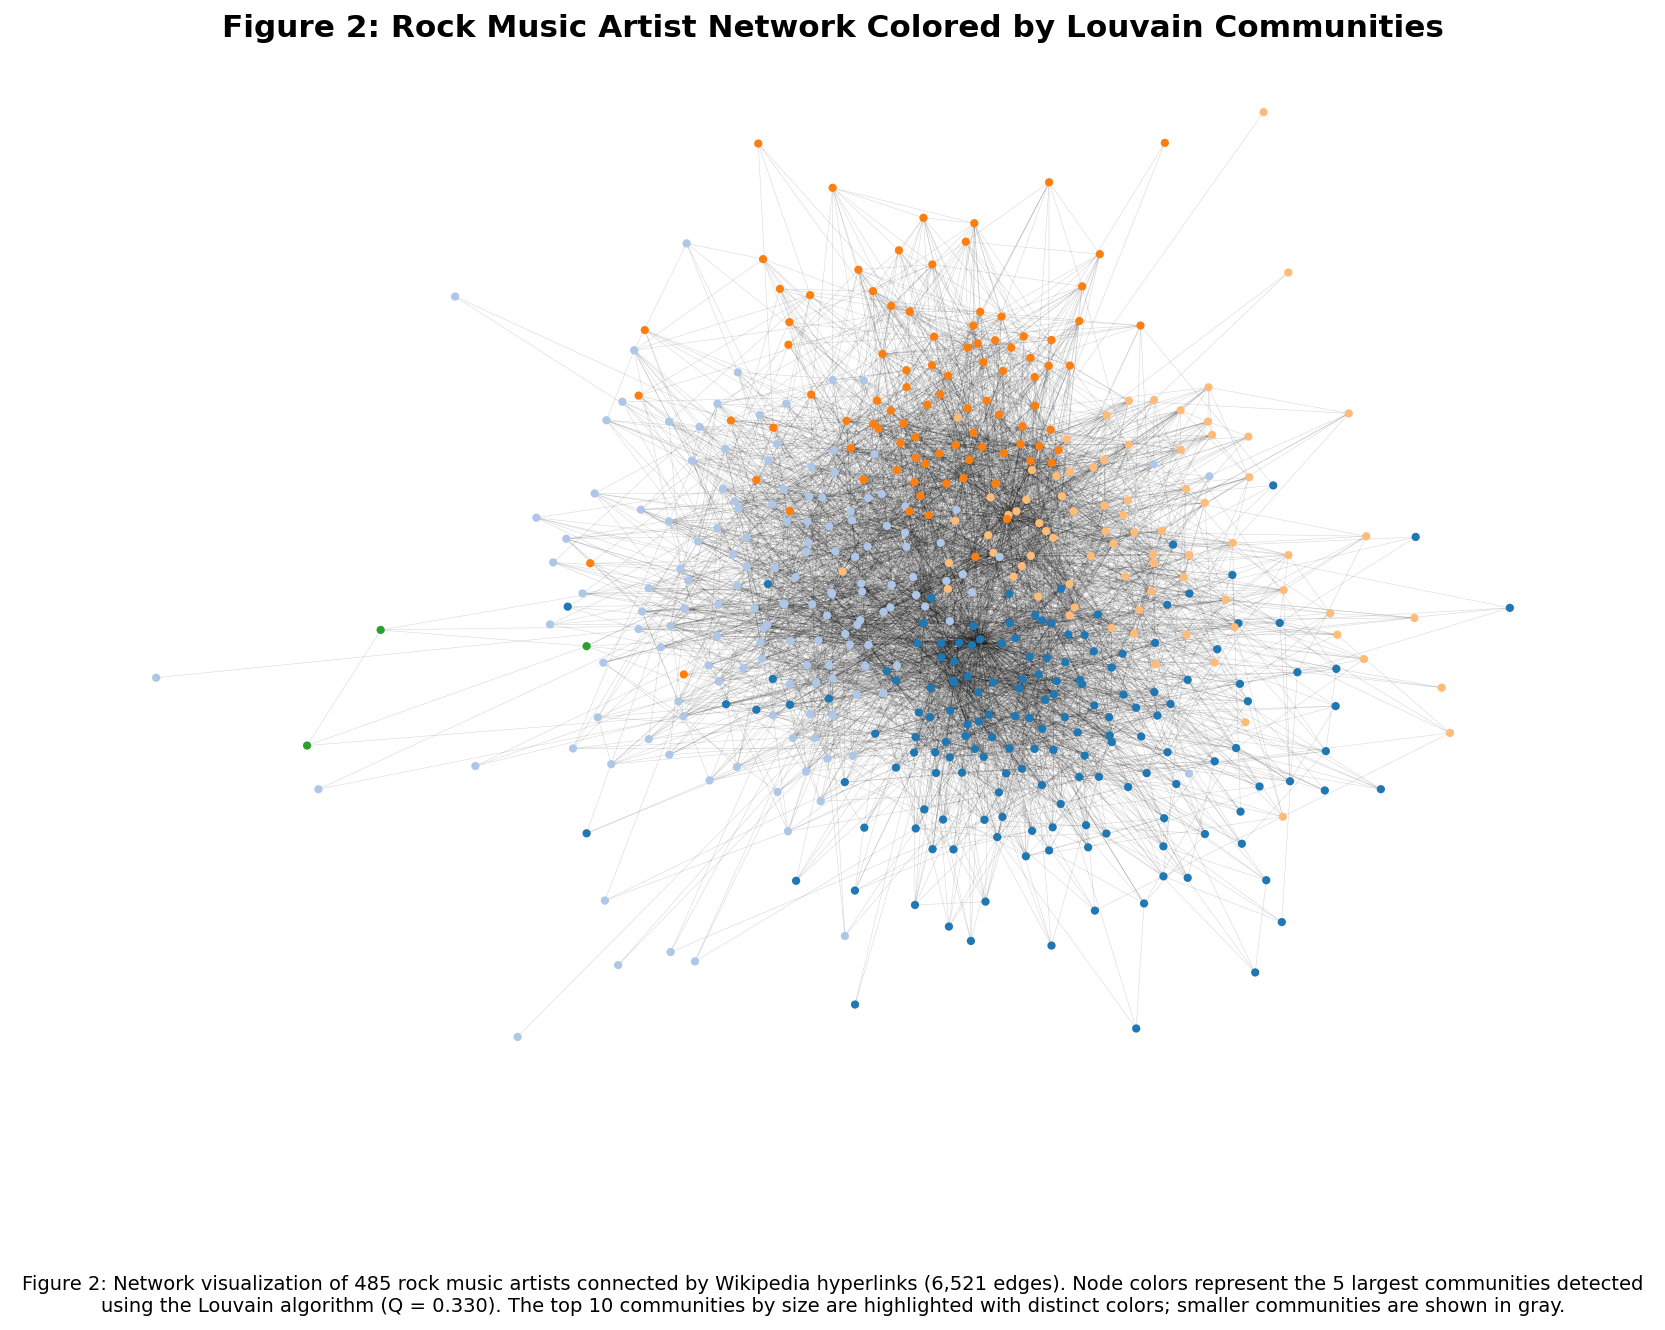

In [76]:
# --- ForceAtlas-style layout (fa2) with fallback to spring_layout ---
import math
import matplotlib.pyplot as plt

# Try ForceAtlas2
pos = None
try:
    from fa2 import ForceAtlas2
    fa2 = ForceAtlas2(
        outboundAttractionDistribution=False,
        linLogMode=False,
        adjustSizes=False,
        edgeWeightInfluence=1.0,
        jitterTolerance=1.0,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=2.0,
        strongGravityMode=False,
        gravity=1.0,
        verbose=False
    )
    pos = fa2.forceatlas2_networkx_layout(H, pos=None, iterations=800)
except Exception:
    # Fallback: Fruchterman-Reingold
    pos = nx.spring_layout(H, k=1/math.sqrt(H.number_of_nodes()), iterations=300, seed=42)

# Map communities to colors (top K colored, others gray)
from matplotlib.cm import get_cmap
from collections import Counter, defaultdict

K = 10  # color the largest K communities
counts = Counter(louvain_part.values())
largest = [cid for cid,_ in counts.most_common(K)]
palette = get_cmap("tab20")

color_map = {}
for i, cid in enumerate(largest):
    color_map[cid] = palette(i % 20)
OTHER_COLOR = (0.8, 0.8, 0.8, 0.4)  # light gray for small communities

node_colors = [color_map.get(louvain_part[n], OTHER_COLOR) for n in H.nodes()]

fig, ax = plt.subplots(figsize=(12, 10), dpi=140)

# Draw network
nx.draw_networkx_edges(H, pos, width=0.3, alpha=0.15, ax=ax)
nx.draw_networkx_nodes(H, pos, node_size=18, node_color=node_colors, linewidths=0, ax=ax)

ax.set_axis_off()

# Scientific figure title and caption
fig.suptitle("Figure 2: Rock Music Artist Network Colored by Louvain Communities", 
            fontsize=16, fontweight='semibold', y=0.95)

# Create a more detailed caption below the plot
caption_text = (f"Figure 2: Network visualization of {H.number_of_nodes():,} rock music artists connected by "
               f"Wikipedia hyperlinks ({H.number_of_edges():,} edges). Node colors represent the {len(counts)} "
               f"largest communities detected using the Louvain algorithm (Q = {Q_louvain:.3f}). "
               f"The top {K} communities by size are highlighted with distinct colors; "
               f"smaller communities are shown in gray.")

# Add caption as text below the plot (centered)
fig.text(0.5, 0.02, caption_text, fontsize=10, ha='center', va='bottom', 
         wrap=True, transform=fig.transFigure)

# Adjust layout to make room for caption
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Increased from 0.12 to 0.15 for more space
plt.show()


### *Confusion matrix* 

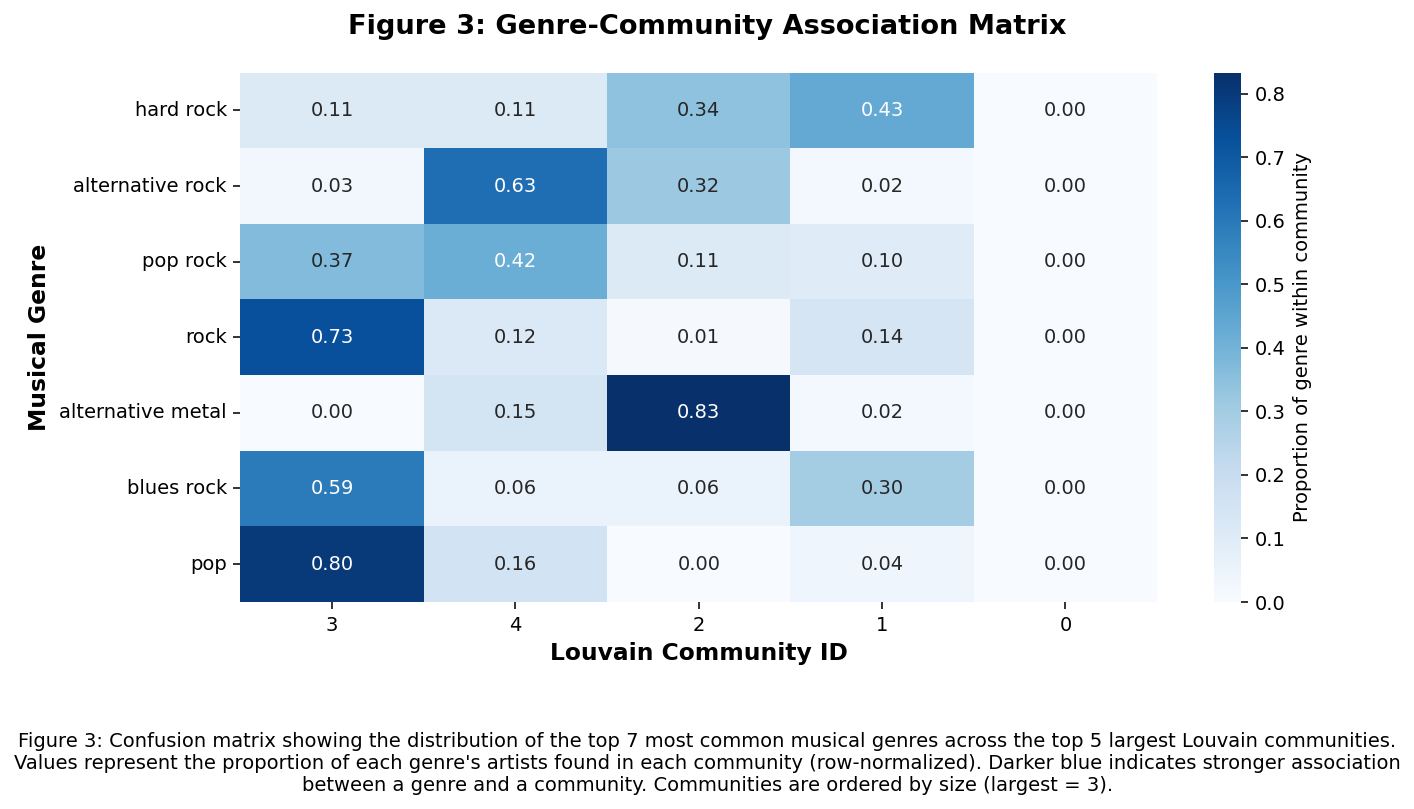

In [77]:
import pandas as pd
from collections import Counter, defaultdict

# --- 2) Determine top 7 genres and top 7 communities ---
all_genres = []
for n in H.nodes():
    g_list = get_genres(n)
    all_genres.extend(g_list)
top_genres = [g for g, _ in Counter(all_genres).most_common(7)]

top_comms = [c for c, _ in Counter(louvain_part.values()).most_common(7)]

# --- 3) Build confusion matrix ---
conf = pd.DataFrame(0, index=top_genres, columns=top_comms, dtype=int)

for n in H.nodes():
    genres = get_genres(n)
    cid = louvain_part.get(n)
    if cid not in top_comms:
        continue
    for g in genres:
        if g in top_genres:
            conf.loc[g, cid] += 1

# Optional: normalize rows to proportions
conf_norm = conf.div(conf.sum(axis=1), axis=0).fillna(0)

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6), dpi=140)

# Create heatmap with better formatting
sns.heatmap(conf_norm, annot=True, fmt=".2f", cmap="Blues", cbar=True, ax=ax,
           cbar_kws={'label': 'Proportion of genre within community'})

# Scientific axis labels and formatting
ax.set_xlabel("Louvain Community ID", fontsize=12, fontweight='bold')
ax.set_ylabel("Musical Genre", fontsize=12, fontweight='bold')

# Scientific figure title
fig.suptitle("Figure 3: Genre-Community Association Matrix", 
            fontsize=14, fontweight='bold', y=0.95)

# Detailed caption
largest_comm_id = top_comms[0]  # The actual largest community ID
caption_text = (f"Figure 3: Confusion matrix showing the distribution of the top {len(top_genres)} most common "
               f"musical genres across the top {len(top_comms)} largest Louvain communities. "
               f"Values represent the proportion of each genre's artists found in each community "
               f"(row-normalized). Darker blue indicates stronger association between a genre "
               f"and a community. Communities are ordered by size (largest = {largest_comm_id}).")

fig.text(0.5, 0.02, caption_text, fontsize=10, ha='center', va='bottom', 
         wrap=True, transform=fig.transFigure)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25, top=0.88)  # Increased from 0.22 to 0.25 for more space
plt.show()
